In [48]:
import pandas as pd
import numpy as np
from ts2vec import TS2Vec
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, silhouette_score, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import umap.umap_ as umap

def load_and_reshape(path):
    df = pd.read_csv(path)

    # Identify duplicates in PatientID + Hours
    if df.duplicated(subset=['PatientID', 'Hours']).any():
        print("Found duplicated PatientID + Hours rows. Dropping them.")
        df = df.drop_duplicates(subset=['PatientID', 'Hours'])

    feature_cols = df.columns.difference(['PatientID', 'Hours'])
    
    # Pivot
    pivot_df = df.pivot(index='PatientID', columns='Hours', values=feature_cols)
    pivot_df = pivot_df.sort_index(axis=1, level=1)

    # Drop any rows with missing values (i.e. incomplete patients)
    pivot_df = pivot_df.dropna()

    return pivot_df.to_numpy().reshape(len(pivot_df), 49, 41), pivot_df.index

df = pd.read_csv("/cluster/home/gcardenal/ML4Healthcare_Project1/enhanced_sampled_set-a.csv")

feature_cols = df.columns.difference(['PatientID', 'Hours'])  # this will be your 41 features

# Pivot to (PatientID, Hours) as index → each feature becomes a time step column
pivot_df = df.pivot(index='PatientID', columns='Hours', values=feature_cols)
pivot_df = pivot_df.sort_index(axis=1, level=1)
reshaped = pivot_df.to_numpy().reshape(4000, 49, 41)  # (patients, time, features)

print(reshaped.shape)  # should be (4000, 49, 41)

(4000, 49, 41)


In [49]:
#TS2Vec does not offer a random state seed option
model = TS2Vec(input_dims=41)
print("Starting model training")
model.fit(reshaped, verbose=True)
print("Training of TS2Vec completed")

Starting model training
Epoch #0: loss=2.2925174894332887
Epoch #1: loss=1.4299555377960205
Training of TS2Vec completed


In [50]:
X_train, train_patient_ids = load_and_reshape("/cluster/home/gcardenal/ML4Healthcare_Project1/enhanced_sampled_set-a.csv")
X_val, val_patient_ids = load_and_reshape("/cluster/home/gcardenal/ML4Healthcare_Project1/enhanced_sampled_set-b.csv")
X_test, test_patient_ids = load_and_reshape("/cluster/home/gcardenal/ML4Healthcare_Project1/enhanced_sampled_set-c.csv")

In [51]:
labels_df_test = pd.read_csv("Outcomes-c.txt")
labels_test = labels_df_test.set_index('RecordID')['In-hospital_death']
test_patient_ids = [pid for pid in test_patient_ids if pd.notna(pid)]
y_test = labels_test.loc[test_patient_ids].to_numpy()

values, counts = np.unique(y_test, return_counts=True)
print(dict(zip(values, counts)))

{0: 2949, 1: 514}


In [52]:
# Compute fixed-size embeddings
Z_train = model.encode(X_train, encoding_window='full') 
Z_train_pooled = Z_train.mean(axis=1) 
Z_val = model.encode(X_val, encoding_window='full')
Z_val_pooled = Z_val.mean(axis=1) 
Z_test = model.encode(X_test, encoding_window='full')
Z_test_pooled = Z_test.mean(axis=1) 

In [53]:
labels_df_train = pd.read_csv("Outcomes-a.txt")
labels_train = labels_df_train.set_index('RecordID')['In-hospital_death']
y_train = labels_train.loc[train_patient_ids].to_numpy()

labels_df_val = pd.read_csv("Outcomes-b.txt")
labels_val = labels_df_val.set_index('RecordID')['In-hospital_death']
y_val = labels_val.loc[val_patient_ids].to_numpy()

labels_df_test = pd.read_csv("Outcomes-c.txt")
labels_test = labels_df_test.set_index('RecordID')['In-hospital_death']
test_patient_ids = [pid for pid in test_patient_ids if pd.notna(pid)]
y_test = labels_test.loc[test_patient_ids].to_numpy()

In [54]:
clf = LogisticRegression(max_iter=1000)
clf.fit(Z_train_pooled, y_train)

# Validation
val_preds = clf.predict(Z_val_pooled)
val_proba = clf.predict_proba(Z_val_pooled)[:, 1]
val_ap = average_precision_score(y_val, val_proba)

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation AUC:", roc_auc_score(y_val, val_proba))
print("Validation Average Precision:", round(val_ap, 4))

# Test
test_preds = clf.predict(Z_test_pooled)
test_proba = clf.predict_proba(Z_test_pooled)[:, 1]
test_ap = average_precision_score(y_test, test_proba)

print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test AUC:", roc_auc_score(y_test, test_proba))
print("Test Average Precision:", round(test_ap, 4))

Validation Accuracy: 0.8695
Validation AUC: 0.8221564233888179
Validation Average Precision: 0.4549
Test Accuracy: 0.8596592549812302
Test AUC: 0.8088094229660386
Test Average Precision: 0.4406


In [55]:
probe_sizes = [100, 500, 1000]
results = {}

# Shuffle training data
X_probe, y_probe = shuffle(Z_train_pooled, y_train, random_state=42)

for size in probe_sizes:
    print(f"\nTraining linear probe with {size} labeled patients")
    
    # Select subset
    X_subset = X_probe[:size]
    y_subset = y_probe[:size]
    
    probe_clf = LogisticRegression(max_iter=1000)
    probe_clf.fit(X_subset, y_subset)
    
    test_preds = probe_clf.predict(Z_test_pooled)
    test_proba = probe_clf.predict_proba(Z_test_pooled)[:, 1]
    
    acc = accuracy_score(y_test, test_preds)
    auc = roc_auc_score(y_test, test_proba)
    ap = average_precision_score(y_test, test_proba)
    
    results[size] = {'Accuracy': acc, 'AUC': auc, 'Average Precision': ap}
    
    print(f"Test Accuracy ({size} samples): {acc:.4f}")
    print(f"Test AUC ({size} samples): {auc:.4f}")
    print(f"Test Average Precision ({size} samples): {ap:.4f}")


Training linear probe with 100 labeled patients
Test Accuracy (100 samples): 0.8184
Test AUC (100 samples): 0.6167
Test Average Precision (100 samples): 0.2154

Training linear probe with 500 labeled patients
Test Accuracy (500 samples): 0.8467
Test AUC (500 samples): 0.7488
Test Average Precision (500 samples): 0.3335

Training linear probe with 1000 labeled patients
Test Accuracy (1000 samples): 0.8519
Test AUC (1000 samples): 0.7768
Test Average Precision (1000 samples): 0.3770


{0: 2949, 1: 514}

Running t-SNE on test set representations...


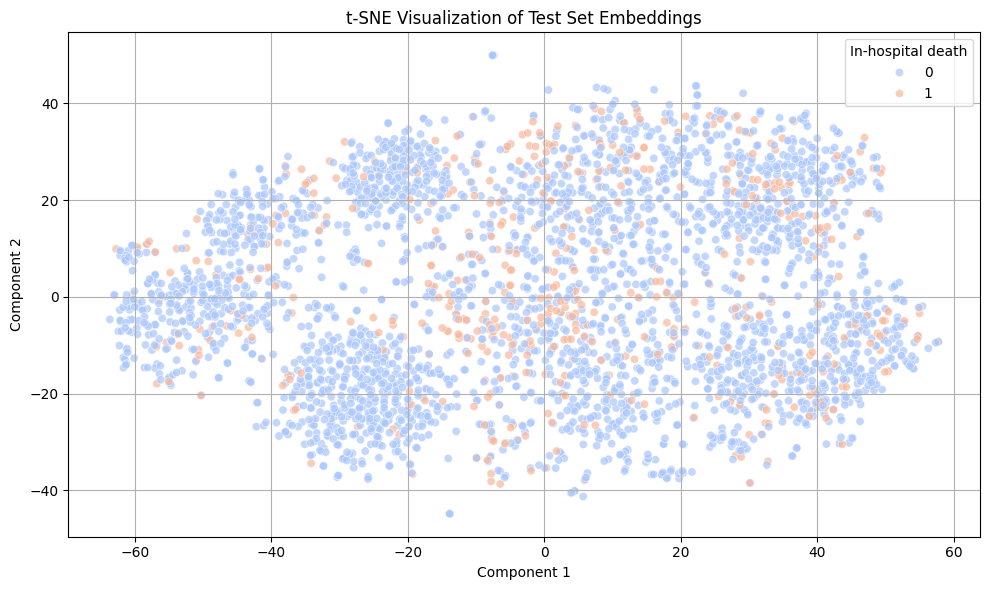

Silhouette Score (w.r.t. class labels): -0.0252


In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns

values, counts = np.unique(y_test, return_counts=True)
print(dict(zip(values, counts)))

print("\nRunning t-SNE on test set representations...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
Z_test_2d = tsne.fit_transform(Z_test_pooled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=Z_test_2d[:, 0], y=Z_test_2d[:, 1], hue=y_test, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization of Test Set Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="In-hospital death")
plt.grid(True)
plt.tight_layout()
plt.savefig("tSNE-test_set.png")
plt.show()

sil_score = silhouette_score(Z_test_2d, y_test)
print(f"Silhouette Score (w.r.t. class labels): {sil_score:.4f}")

/cluster/home/gcardenal/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


True labels: [0 1 0 ... 0 0 0]
Cluster labels [0 1 0 ... 0 0 0]
Adjusted Rand Index: -0.006
Silhouette Score (w.r.t. class labels): -0.0421


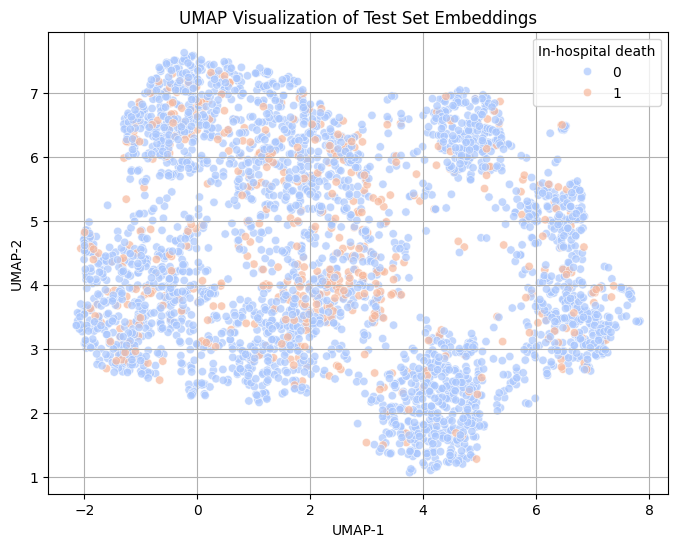

In [57]:
reducer = umap.UMAP(n_components=2, random_state=42)
Z_test_2d = reducer.fit_transform(Z_test_pooled)

# Cluster using KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(Z_test_pooled)

sil_score = silhouette_score(Z_test_2d, y_test)
ari = adjusted_rand_score(y_test, clusters)
print(f"True labels: {y_test}")
print(f"Cluster labels {y_test}")
print(f'Adjusted Rand Index: {ari:.3f}')
print(f"Silhouette Score (w.r.t. class labels): {sil_score:.4f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=Z_test_2d[:, 0], y=Z_test_2d[:, 1], hue=y_test, palette="coolwarm", alpha=0.7)
plt.legend(title="In-hospital death")
plt.title(f'UMAP Visualization of Test Set Embeddings')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.grid(True)
plt.savefig("UMAP-test_set.png")
plt.show()

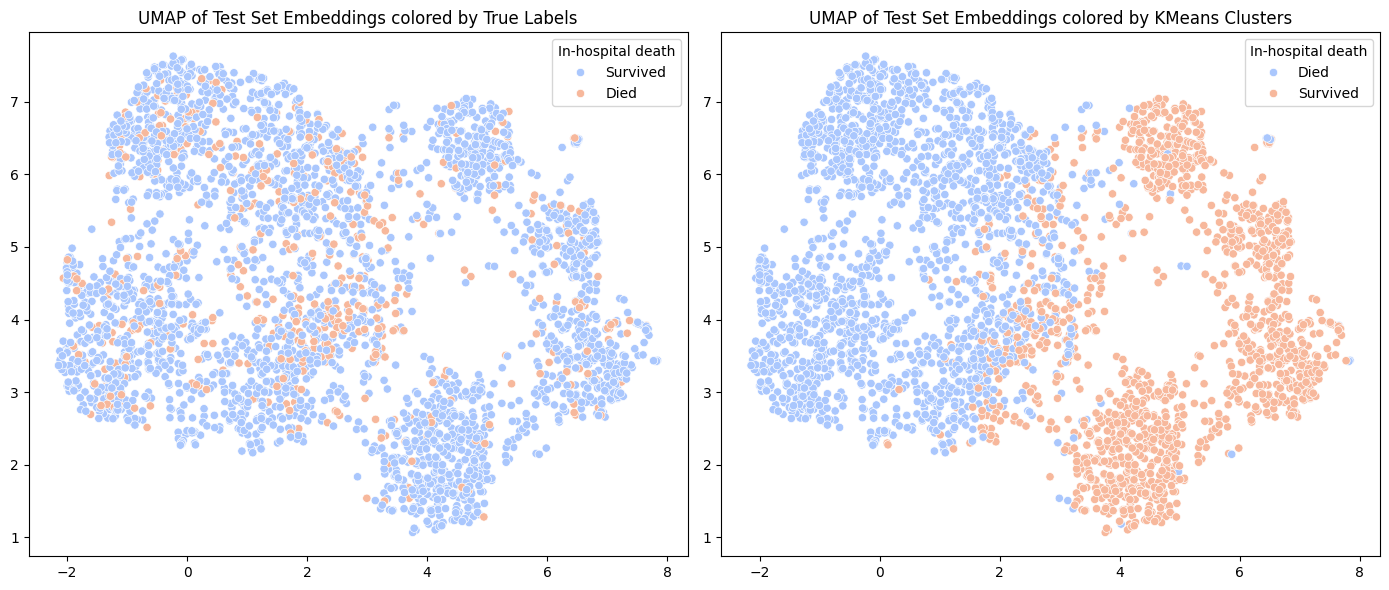

In [58]:
#Comparing both
label_map = {0: "Survived", 1: "Died"}

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    x=Z_test_2d[:, 0],
    y=Z_test_2d[:, 1],
    hue=[label_map[label] for label in y_test],
    palette="coolwarm",
    ax=axs[0]
)
axs[0].set_title("UMAP of Test Set Embeddings colored by True Labels")
axs[0].legend(title="In-hospital death")

sns.scatterplot(
    x=Z_test_2d[:, 0],
    y=Z_test_2d[:, 1],
    hue=[label_map[label] for label in clusters],
    palette="coolwarm",
    ax=axs[1]
)
axs[1].set_title("UMAP of Test Set Embeddings colored by KMeans Clusters")
axs[1].legend(title="In-hospital death")

plt.tight_layout()
plt.savefig("UMAP-comparison.png")
plt.show()